**Cale Kochenour** \
GEOG 5563 \
May 1, 2020

# aWhere API Python Solution

## Introduction

This workflow defines a [Python](https://www.python.org/) solution for the [aWhere API](https://www.awhere.com/weather-insights/). The specific science goal for this task was to wrangle the aWhere data into a usable format, such that it could be integrated with other GIS and remote sensing data, in support of fire risk and drought monitoring analyses.

Methods needed to go from API to usable data in Python included the ability to: 

* **Get** data from the API;
* **Extract** data from the API return; and; 
* **Clean** and georeference extracted data.

## Previous Work

Though this project was largely created from scratch (there is no current, public Python solution for the API), the [aWhere R code](https://github.com/aWhereAPI/aWhere-R-Library/tree/master/R) provided insight into current implementation and capabilities with the [R](https://www.r-project.org/about.html) programming language. In addition, this project started by reviewing and building upon the [aWhere Python-specific examples](https://github.com/aWhereAPI/API-Code-Samples/tree/master/python) for connecting to the API as well as the [aWhere API documentation](https://docs.awhere.com/knowledge-base-docs/api-reference/).

## Workflow

This workflow relies on two custom scripts, `awhere_classes.py` and `awhere_grid.py`, to retrieve the aWhere data, wrangle it into a usable format, and apply the functionality to a case study near [Rocky Mountain National Park, Colorado](https://www.nps.gov/romo/index.htm). 

The `awhere_classes.py` custom script contains the full Alpha (0.1) version of the Python classes and methods used to **get**, **extract**, and **clean** aWhere API data. This functionality provides connections to all available aWhere data (except the [batch job system](https://docs.awhere.com/knowledge-base-docs/batch-jobs/)), to include:

* [Fields & Plantings](https://docs.awhere.com/knowledge-base-docs/field-plantings/);
* [Weather](https://docs.awhere.com/knowledge-base-docs/weather/);
* [Agronomics](https://docs.awhere.com/knowledge-base-docs/agronomics/);
* [Models](https://docs.awhere.com/knowledge-base-docs/models/); and,
* [APIs by Geolocation](https://docs.awhere.com/knowledge-base-docs/apis-by-geolocation/).

The `awhere_grid.py` custom script contains the Python code to create an aWhere-sized grid (9x9 km) from a shapefile and extract tile centroids from that grid. This code was based on the [aWhere R code](https://github.com/aWhereAPI/aWhere-R-Library/blob/master/R/create-awhere-grid.R) used for the same purpose.

This Jupyter Notebook demonstrates the Python solution using Agronomics and Weather data in Rocky Mountain National Park, Colorado and compares the observed precipitation data to the average precipitation data, for the 10-day period from May 4, 2014 to May 13, 2014.

### Environment Setup

In addition to importing packages necessary for navigating paths and plotting data, this workflow imports the two custom scripts, `awhere_classes.py` and `awhere_grid.py`, in order to use the specific aWhere-related Python functionality.

In order for the workflow to successfully run, an active connection to the aWhere API must exist, via an API Key and API Secret. The key-secret pair is created once an application is created within the [aWhere developer platform](https://www.awhere.com/developer/) (aWhere developer account required). 

In [1]:
# Imports
import os
import matplotlib.pyplot as plt
import earthpy as et
from awhere_classes import *
import awhere_grid as ag

# Show all pandas columns and rows
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [2]:
# Define aWhere API key and secret
api_key = os.environ.get('AWHERE_API_KEY')
api_secret = os.environ.get('AWHERE_API_SECRET')

In [3]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, 'earth-analytics', 
    '03-geog5663-earth-analytics-applications-summer-2020',
    'git-repos', 'fire-drought-analysis')

### Create aWhere Grid

The aWhere grid assumes a 9x9 km (0.08 degrees) tile size (one weather data point within each tile), and the Python solution creates this grid from a shapefile boundary. The user may input a buffer size in order o make sure all parts of the study area are contained within an aWhere grid cell. This workflow demonstrates the creation of a grid based on the [Rocky Mountain National Park boundary](https://romo-nps.opendata.arcgis.com/datasets/rocky-mountain-national-park-boundary-polygon) and then analyzes data from a single grid cell.

In [4]:
# Define path to Bernardo fire extent boundary
rmnp_bound_path = os.path.join(
    working_directory, '02-raw-data', 'co-rmnp', 'rmnp_boundary.shp')

In [5]:
# Project fire bounary to 4236 (for plotting)
rmnp_bound_4326 = gpd.read_file(rmnp_bound_path).to_crs(4326)

C:\.conda\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [6]:
# Create aWhere grid for Bernardo extent
rmnp_grid = ag.create_awhere_grid(rmnp_bound_path, buffer_distance=.12)

C:\.conda\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


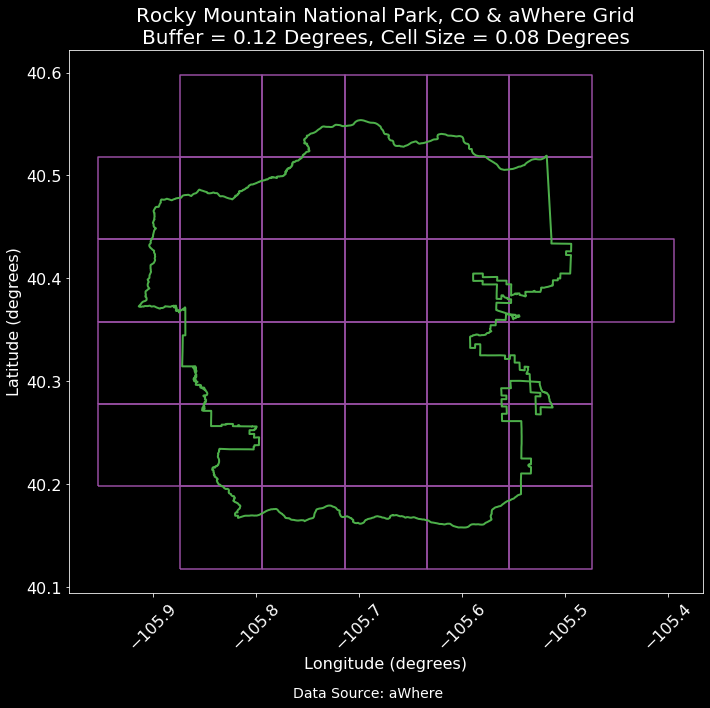

In [7]:
# Plot boundary (4326) and grid
with plt.style.context('dark_background'):

    fig, ax = plt.subplots(figsize=(20, 10))
    rmnp_grid.plot(ax=ax, facecolor="none",
                       edgecolor="#984ea3", linewidth=1.5, 
                       label='aWhere Grid', legend=True)
    rmnp_bound_4326.plot(ax=ax, facecolor="none",
                             edgecolor="#4daf4a", linewidth=2,
                             label='Bernardo Fire Extent', legend=True)

    ax.set_xlabel("Longitude (degrees)", fontsize=16)
    ax.set_ylabel("Latitude (degrees)", fontsize=16)
    ax.set_title(
        "Rocky Mountain National Park, CO & aWhere Grid\nBuffer = 0.12 Degrees, Cell Size = 0.08 Degrees",
        fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(rotation=45)
    
    fig.text(0.5, -0.02, "Data Source: aWhere",
             ha='center', fontsize=14)
 
    plt.show()

### Extract Grid Centroids

This workflow demonstrates a data call to aWhere with the [APIs by Geolocation](https://docs.awhere.com/knowledge-base-docs/apis-by-geolocation/) implementation. The API uses a point (longitude, latitude) to locate data, which makes it necessary to extract a single point within the grid cell to use as a case study. The aWhere 9x9 km grid cell concept means that all data within a grid cell will return the same data. The `awhere_grid.py` script ensures at least one data point exists in each grid tile, and the specific point used is the grid tile centroid. For the purpose of this case study, a single centroid is used to demonstrate the extraction of precipitation data.   

In [8]:
# Extract grid centroids to list
rmnp_grid_centroids = ag.extract_centroids(rmnp_grid)

In [9]:
# Display first centroid
rmnp_grid_centroids[0]

(-105.91371876783066, 40.23807909092806)

In [10]:
# Display all centroids
rmnp_grid_centroids

[(-105.91371876783066, 40.23807909092806),
 (-105.91371876783066, 40.31807909092806),
 (-105.91371876783066, 40.398079090928064),
 (-105.91371876783066, 40.47807909092805),
 (-105.83371876783065, 40.15807909092806),
 (-105.83371876783065, 40.23807909092806),
 (-105.83371876783065, 40.31807909092806),
 (-105.83371876783065, 40.398079090928064),
 (-105.83371876783065, 40.47807909092805),
 (-105.83371876783065, 40.558079090928054),
 (-105.75371876783065, 40.15807909092806),
 (-105.75371876783065, 40.23807909092806),
 (-105.75371876783065, 40.31807909092806),
 (-105.75371876783065, 40.398079090928064),
 (-105.75371876783065, 40.47807909092805),
 (-105.75371876783065, 40.558079090928054),
 (-105.67371876783066, 40.15807909092806),
 (-105.67371876783066, 40.23807909092806),
 (-105.67371876783066, 40.31807909092806),
 (-105.67371876783066, 40.398079090928064),
 (-105.67371876783066, 40.47807909092805),
 (-105.67371876783066, 40.558079090928054),
 (-105.59371876783067, 40.15807909092806),
 (-1

### Get aWhere API Data

Getting data from the Python solution of the aWhere [APIs by Geolocation](https://docs.awhere.com/knowledge-base-docs/apis-by-geolocation/) implementation requires:

* API Key;
* API Secret;
* Longitude;
* Latitude; and,
* Other required parameters (different for each type of data).

Other parameters for this case study include dates, both specific month/day/year combinations for observed data and specific month/day combinations for average/norms data. This case study uses the longitude and latitude values from one grid tile centroid in the Rocky Mountain National Park grid to retrieve and analyze data.

In [11]:
# Define kwargs (parameters from get_data)
values_kwargs ={'start_day': '2014-05-04' , 'end_day': '2014-05-13'}
norms_kwargs ={'start_day': '05-04' , 'end_day': '05-13'}

#### Weather Norms, 05-04 to 05-13

In [12]:
# Define WeatherLocationNorms object
weather_norms_object = WeatherLocationNorms(
    api_key, api_secret, latitude=rmnp_grid_centroids[0][1], 
    longitude=rmnp_grid_centroids[0][0])

In [13]:
# Create geodataframe
weather_norms_gdf = WeatherLocationNorms.api_to_gdf(
    weather_norms_object, kwargs=norms_kwargs)

In [14]:
# Display geodataframe
weather_norms_gdf

mean_temp_avg_cels  mean_temp_std_dev_cels  max_temp_avg_cels  \
day                                                                    
05-04              7.5330                3.072114             14.922   
05-05              8.1805                2.779992             16.365   
05-06              8.2615                2.983118             15.425   
05-07              6.8775                3.841544             13.036   
05-08              5.7170                3.595947             11.976   
05-09              6.5645                4.472970             13.449   
05-10              6.0450                4.102232             12.122   
05-11              4.6300                3.773490             10.648   
05-12              5.4780                4.758887             12.213   
05-13              7.3900                4.834935             14.123   

       max_temp_std_dev_cels  min_temp_avg_cels  min_temp_std_dev_cels  \
day                                                                      
05-04               4.794972              0.144               2.377619   
05-05               3.960890             -0.004               2.475113   
05-06               4.417370              1.098               2.124188   
05-07               5.147270              0.719               2.957196   
05-08               5.443014             -0.542               2.490305   
05-09               6.757038             -0.320               2.832541   
05-10               6.200553             -0.032               2.635117   
05-11               5.372100             -1.388               2.647476   
05-12               7.044150             -1.257               3.060665   
05-13               6.043963              0.657               3.963237   

       precip_avg_mm  precip_std_dev_mm  solar_avg_w_h_per_m2  \
day                                                             
05-04       0.125800           0.397815           6173.843921   
05-05       0.154352           0.398029           6562.428027   
05-06       0.771379           1.546673           5727.726855   
05-07       3.074469           3.521206           5256.325562   
05-08       0.669800           1.125850           5173.111353   
05-09       3.127800           5.288446           5219.131421   
05-10       1.445050           2.478485           5014.628198   
05-11       2.379500           5.241635           4719.704419   
05-12       1.073600           2.463435           5337.571362   
05-13       1.442400           2.904577           5809.285791   

       solar_avg_std_dev_w_h_per_m2  min_humiduty_avg_%  \
day                                                       
05-04                   1595.734861           23.269000   
05-05                   1414.852615           20.857000   
05-06                   1293.423446           26.225000   
05-07                   1394.645794           35.589999   
05-08                   1999.583560           38.840001   
05-09                   1688.535257           35.984000   
05-10                   1569.683150           35.595000   
05-11                   1697.492050           41.296000   
05-12                   1968.730129           35.405000   
05-13                   1382.606578           29.272000   

       min_humidity_std_dev_%  max_humiduty_avg_%  max_humidity_std_dev_%  \
day                                                                         
05-04               14.108169           73.658000               16.066586   
05-05               14.692513           76.624999               12.906793   
05-06               15.440442           78.180000               17.063363   
05-07               19.447952           84.893000               12.035918   
05-08               21.116084           88.642999               14.360916   
05-09               20.130863           87.616001               12.978156   
05-10               20.581192           89.287999               12.242263   
05-11               21.945795           94.477000                4.008

In [15]:
# Get precip avg
rmnp_precip_norms = weather_norms_gdf[['precip_avg_mm']]

#### Weather Observed, 2014-05-04 to 2014-05-13

In [16]:
# Define WeatherLocationObserved object
weather_observed_object = WeatherLocationObserved(
    api_key, api_secret, latitude=rmnp_grid_centroids[0][1], 
    longitude=rmnp_grid_centroids[0][0])

In [17]:
# Create geodataframe
weather_observed_gdf = WeatherLocationObserved.api_to_gdf(
    weather_observed_object, kwargs=values_kwargs)

In [18]:
# Display geodataframe
weather_observed_gdf

temp_max_cels  temp_min_cels  precip_amount_mm  \
date                                                         
2014-05-04      20.280001           4.32            1.2580   
2014-05-05      18.030001           1.96            1.2580   
2014-05-06      17.070000           1.68            4.3065   
2014-05-07      12.900000          -0.44            2.1530   
2014-05-08       6.230000          -1.91            2.1530   
2014-05-09      10.500000          -2.10            0.0000   
2014-05-10       9.330000          -0.65            0.0000   
2014-05-11       2.850000          -4.13            8.3240   
2014-05-12       0.840000          -5.37            0.0000   
2014-05-13       3.730000          -7.16            0.0000   

            solar_energy_w_h_per_m2  rel_humidity_max_%  rel_humidity_min_%  \
date                                                                          
2014-05-04              7388.182617           47.369999            8.580000   
2014-05-05              7386.245605           54.430000            8.510000   
2014-05-06              6866.908691           61.680000           13.120000   
2014-05-07              5217.457520           79.730003           25.059999   
2014-05-08              3384.469238           99.279999           53.009998   
2014-05-09              4775.274414           96.720001           46.580002   
2014-05-10              4214.401367           98.019997           49.189999   
2014-05-11              2443.861084          100.000000           77.669998   
2014-05-12              3452.642090           95.269997           51.169998   
2014-05-13              6353.942871           88.709999           39.250000   

            wind_morning_max_m_per_sec  wind_day_max_m_per_sec  \
date                                                             
2014-05-04                   11.433436               12.690346   
2014-05-05                    7.308416                8.595894   
2014-05-06                    6.511608                8.717894   
2014-05-07                    8.000993                9.787355   
2014-05-08                    5.630669                7.863203   
2014-05-09                    7.506359               11.326076   
2014-05-10                    6.696489                8.503947   
2014-05-11                    7.579279                9.010052   
2014-05-12                    6.996462                7.617424   
2014-05-13                    5.194660                6.481265   

            wind_avg_m_per_sec                     geometry  
date                                                         
2014-05-04            6.269575  POINT (-105.91372 40.23808)  
2014-05-05            4.185597  POINT (-105.91372 40.23808)  
2014-05-06            3.744873  POINT (-105.91372 40.23808)  
2014-05-07            4.377469  POINT (-105.91372 40.23808)  
2014-05-08            4.005401  POINT (-105.91372 40.23808)  
2014-05-09            4.811516  POINT (-105.91372 40.23808)  
2014-05-10            4.304587  POINT (-105.91372 40.23808)  
2014-05-11            4.556049  POINT (-105.91372 40.23808)  
2014-05-12            4.388861  POINT (-105.91372 40.23808)  
2014-05-13            2.876682  POINT (-105.91372 40.23808)

In [19]:
# Get precip amount
rmnp_precip_observed = weather_observed_gdf[['precip_amount_mm']]

# Change date (YYYY-MM-DD) to day (MM-DD) for plotting
days = [value[5:] for value in rmnp_precip_observed.index.values]
rmnp_precip_observed.insert(1, "day", days, True)
rmnp_precip_observed.set_index('day', inplace=True)

#### Agronomic Norms, 05-04 to 05-13

In [20]:
# Define AgronomicLocationNorms object
agronomic_object = AgronomicsLocationNorms(
    api_key, api_secret, latitude=rmnp_grid_centroids[0][1], 
    longitude=rmnp_grid_centroids[0][0])

In [21]:
# Create geodataframe - date range
ag_norms_total_accum_gdf, ag_norms_daily_accum_gdf = AgronomicsLocationNorms.api_to_gdf(
    agronomic_object, value_type='multi_day', kwargs=norms_kwargs)

In [22]:
# Display geodataframe - total
ag_norms_total_accum_gdf

gdd_range_average_total_cels  \
date_range                                  
05-04/05-13                         4.085   

             gdd_range_average_total_std_dev_cels  \
date_range                                          
05-04/05-13                              3.724949   

             precip_range_average_total_mm  \
date_range                                   
05-04/05-13                       14.26415   

             precip_range_average_total_std_dev_mm  \
date_range                                           
05-04/05-13                               5.814561   

             pet_range_average_total_mm  pet_range_average_total_std_dev  \
date_range                                                                 
05-04/05-13                   35.139082                         6.313705   

             ppet_range_daily_average  ppet_range_daily_average_std_dev  \
date_range                                                                
05-04/05-13                  0.719814                          0.457642   

            start_day end_day                     geometry  
date_range                                                  
05-04/05-13     05-04   05-13  POINT (-105.91372 40.23808)

In [23]:
# Display dataframe - daily
ag_norms_daily_accum_gdf

gdd_daily_average_cels  gdd_daily_average_std_dev_cels  \
day                                                             
05-04                  0.5320                        1.134321   
05-05                  0.3880                        0.639966   
05-06                  0.4620                        0.940591   
05-07                  0.4900                        0.844456   
05-08                  0.2400                        0.505970   
05-09                  0.3860                        0.968750   
05-10                  0.4830                        1.027078   
05-11                  0.1475                        0.466436   
05-12                  0.2470                        0.455175   
05-13                  0.7095                        1.537792   

       pet_daily_average_mm  pet_daily_average_std_dev_mm  ppet_daliy_average  \
day                                                                             
05-04              4.157771                      1.445996            0.019047   
05-05              4.335471                      1.104296            0.030059   
05-06              3.919487                      1.109033            0.166118   
05-07              3.334133                      1.261635            1.225682   
05-08              3.141415                      1.482968            0.291558   
05-09              3.378663                      1.494726            1.509476   
05-10              3.191760                      1.375819            0.728984   
05-11              2.772233                      1.135621            2.245943   
05-12              3.258234                      1.429350            0.337824   
05-13              3.649917                      1.296287            0.643447   

       ppet_daily_average_std_dev  gdd_rolling_total_average  \
day                                                            
05-04                    0.060233                     0.5320   
05-05                    0.074147                     0.9200   
05-06                    0.323895                     1.3820   
05-07                    1.652719                     1.8720   
05-08                    0.517764                     2.1120   
05-09                    2.731790                     2.4980   
05-10                    1.510522                     2.9810   
05-11                    4.997603                     3.1285   
05-12                    0.721232                     3.3755   
05-13                    1.425351                     4.0850   

       gdd_rolling_total_average_std_dev  precip_rolling_total_average_mm  \
day                                                                         
05-04                           1.134321                         0.125800   
05-05                           1.521405                         0.280152   
05-06                           1.829590                         1.051531   
05-07                           2.090592                         4.126000   
05-08                           2.144006                         4.795800   
05-09                           2.424412                         7.923600   
05-10                           3.042637                         9.368650   
05-11                           3.304847                        11.748150   
05-12                           3.392997                        12.821750   
05-13                           3.724949                        14.264150   

       precip_rolling_total_average_std_dev_mm  pet_rolling_total_average_mm  \
day                                                                            
05-04                                 0.397815                      4.157771   
05-05                                 0.790705                      8.493242   
05-06                                 2.230184                     12.412728   
05-07                                 4.401782                     15.746861   
05-08                                 5.366871                     18.888276   

In [24]:
# Get rolling total average
rmnp_agro_norms = ag_norms_daily_accum_gdf[['precip_rolling_total_average_mm']]

#### Agronomic Values, 2014-05-04 to 2014-05-13

In [25]:
# Define AgronomicLocationValues object
agronomic_values_object = AgronomicsLocationValues(
    api_key, api_secret, latitude=rmnp_grid_centroids[0][1], 
    longitude=rmnp_grid_centroids[0][0])

In [26]:
# Create geodataframe - date range
ag_vals_total_accum_gdf, ag_vals_daily_accum_gdf = AgronomicsLocationValues.api_to_gdf(
    agronomic_values_object, value_type='multi_day', kwargs=values_kwargs)

In [27]:
# Display geodataframe - total
ag_vals_total_accum_gdf

gdd_range_total_cels  ppet_range_total  \
date_range                                                      
2014-05-04/2014-05-13                   2.3         10.787635   

                       precip_range_total_mm  pet_range_total_mm   start_day  \
date_range                                                                     
2014-05-04/2014-05-13              19.452501           32.485142  2014-05-04   

                          end_day                     geometry  
date_range                                                      
2014-05-04/2014-05-13  2014-05-13  POINT (-105.91372 40.23808)

In [28]:
# Display dataframe - daily
ag_vals_daily_accum_gdf

gdd_daily_total_cels  ppet_daily_total  gdd_rolling_total_cels  \
date                                                                         
2014-05-04                   2.3          0.190473                     2.3   
2014-05-05                   0.0          0.231958                     2.3   
2014-05-06                   0.0          0.885854                     2.3   
2014-05-07                   0.0          0.595278                     2.3   
2014-05-08                   0.0          1.164659                     2.3   
2014-05-09                   0.0          0.000000                     2.3   
2014-05-10                   0.0          0.000000                     2.3   
2014-05-11                   0.0          7.719412                     2.3   
2014-05-12                   0.0          0.000000                     2.3   
2014-05-13                   0.0          0.000000                     2.3   

            ppet_rolling_total  pet_daily_total_mm  precip_rolling_total_mm  \
date                                                                          
2014-05-04            0.190473            6.604603                 1.258000   
2014-05-05            0.422432            5.423386                 2.516000   
2014-05-06            1.308286            4.861410                 6.822500   
2014-05-07            1.903564            3.616797                 8.975500   
2014-05-08            3.068223            1.848610                11.128500   
2014-05-09            3.068223            2.676341                11.128500   
2014-05-10            3.068223            2.381153                11.128500   
2014-05-11           10.787635            1.078320                19.452501   
2014-05-12           10.787635            1.545299                19.452501   
2014-05-13           10.787635            2.449223                19.452501   

            pet_rolling_total_mm                     geometry  
date                                                           
2014-05-04              6.604603  POINT (-105.91372 40.23808)  
2014-05-05             12.027989  POINT (-105.91372 40.23808)  
2014-05-06             16.889400  POINT (-105.91372 40.23808)  
2014-05-07             20.506196  POINT (-105.91372 40.23808)  
2014-05-08             22.354807  POINT (-105.91372 40.23808)  
2014-05-09             25.031147  POINT (-105.91372 40.23808)  
2014-05-10             27.412300  POINT (-105.91372 40.23808)  
2014-05-11             28.490620  POINT (-105.91372 40.23808)  
2014-05-12             30.035920  POINT (-105.91372 40.23808)  
2014-05-13             32.485142  POINT (-105.91372 40.23808)

In [29]:
# Get rolling total
rmnp_agro_observed = ag_vals_daily_accum_gdf[['precip_rolling_total_mm']]

# Change date (YYYY-MM-DD) to day (MM-DD) for plotting
days = [value[5:] for value in rmnp_agro_observed.index.values]
rmnp_agro_observed.insert(1, "day", days, True)
rmnp_agro_observed.set_index('day', inplace=True)

### Combine Data for Plotting

Once all data is retrieved and returned, the workflow isolates precipitation data (observed and average) for plotting and calculates the differences between the observed values and the average values.

In [30]:
# Merge precip and agro indivdual components (norms and observed for both)
rmnp_precip_may_2014 = rmnp_precip_observed.merge(rmnp_precip_norms, on='day')
rmnp_agro_may_2014 = rmnp_agro_observed.merge(rmnp_agro_norms, on='day')

# Merge precip and agro together
rmnp_may_2014 = rmnp_precip_may_2014.merge(rmnp_agro_may_2014, on='day')

In [31]:
# Add columns for differences between observed and norms
rmnp_may_2014['precip_daily_total_diff_mm'] = rmnp_may_2014.precip_amount_mm - \
     rmnp_may_2014.precip_avg_mm

rmnp_may_2014['precip_rolling_total_diff_mm'] = rmnp_may_2014.precip_rolling_total_mm - \
    rmnp_may_2014.precip_rolling_total_average_mm

In [32]:
# Display dataframe
rmnp_may_2014

precip_amount_mm  precip_avg_mm  precip_rolling_total_mm  \
day                                                               
05-04            1.2580       0.125800                 1.258000   
05-05            1.2580       0.154352                 2.516000   
05-06            4.3065       0.771379                 6.822500   
05-07            2.1530       3.074469                 8.975500   
05-08            2.1530       0.669800                11.128500   
05-09            0.0000       3.127800                11.128500   
05-10            0.0000       1.445050                11.128500   
05-11            8.3240       2.379500                19.452501   
05-12            0.0000       1.073600                19.452501   
05-13            0.0000       1.442400                19.452501   

       precip_rolling_total_average_mm  precip_daily_total_diff_mm  \
day                                                                  
05-04                         0.125800                    1.132200   
05-05                         0.280152                    1.103648   
05-06                         1.051531                    3.535121   
05-07                         4.126000                   -0.921469   
05-08                         4.795800                    1.483200   
05-09                         7.923600                   -3.127800   
05-10                         9.368650                   -1.445050   
05-11                        11.748150                    5.944500   
05-12                        12.821750                   -1.073600   
05-13                        14.264150                   -1.442400   

       precip_rolling_total_diff_mm  
day                                  
05-04                      1.132200  
05-05                      2.235848  
05-06                      5.770969  
05-07                      4.849500  
05-08                      6.332700  
05-09                      3.204900  
05-10                      1.759850  
05-11                      7.704351  
05-12                      6.630751  
05-13                      5.188351

### Visualize Precipitation Data

The workflow presents three figures that focus on observed and average precipitation data, and show how:

* Daily values for observed and average data contribute to the rolling total;
* Daily values for the observed data compare to the average data;
* Rolling total for the observed data compares to the average data.

Data is shown for May 4 - May 13, with the observed values from 2014 being used.

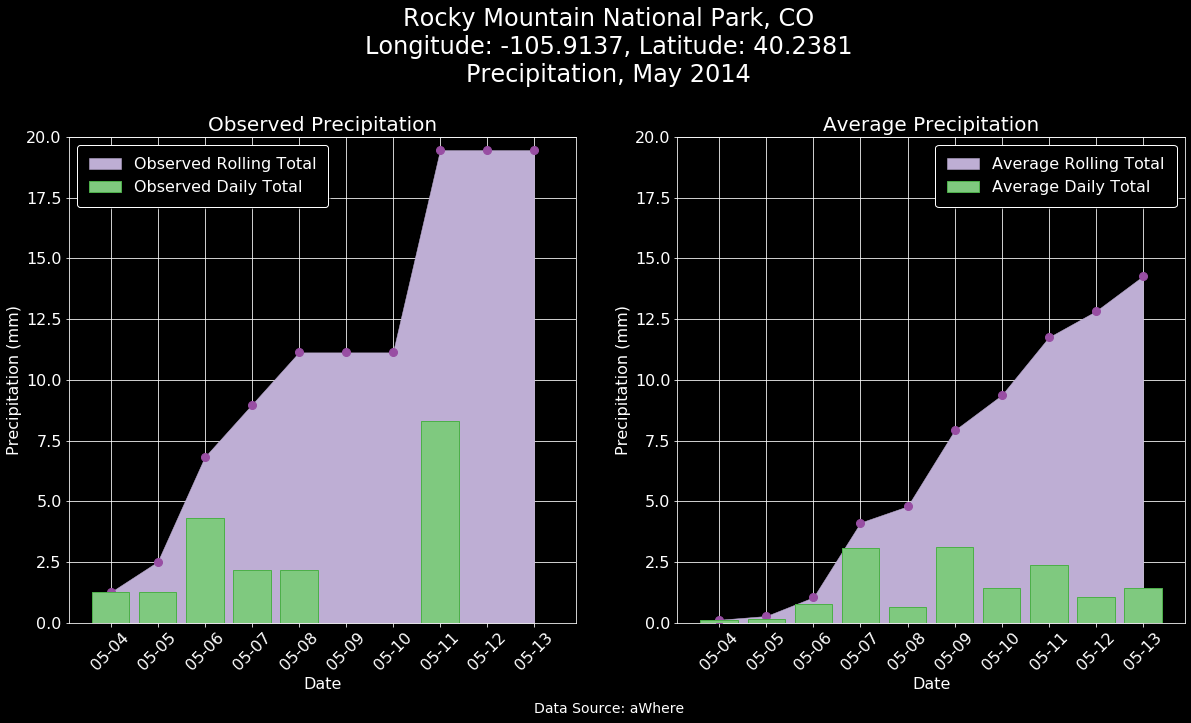

In [33]:
# Plot accumulation (observed and norms)
with plt.style.context('dark_background'):

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Set overall title
    plt.suptitle(
        f'Rocky Mountain National Park, CO\nLongitude: {round(rmnp_grid_centroids[0][0], 4)}, Latitude: {round(rmnp_grid_centroids[0][1], 4)}\nPrecipitation, May 2014',
        fontsize=24)

    plt.subplots_adjust(top=0.8)

    # Subplot 1 - Observed Precipitation
    # Creat grid
    ax[0].grid(zorder=1)

    # Add daily total (bar)
    ax[0].bar(
        rmnp_may_2014.index.values, rmnp_may_2014.precip_amount_mm,
        label='Observed Daily Total', color='#7fc97f',
        linewidth=1, zorder=4, edgecolor='#4daf4a', alpha=1)

    # Add rolling total (line)
    ax[0].plot(
        rmnp_may_2014.precip_rolling_total_mm, marker='o',
        color='#984ea3', markersize=8, linewidth=0,
        linestyle='--', zorder=3)

    # Add rolling total (fill)
    ax[0].fill_between(
        rmnp_may_2014.index.values, rmnp_may_2014.precip_rolling_total_mm,
        label='Observed Rolling Total', color='#beaed4',
        linewidth=0.5, linestyle='-', zorder=2, alpha=1)

    # Configure axes
    ax[0].set_xlabel("Date", fontsize=16)
    ax[0].set_ylabel("Precipitation (mm)", fontsize=16)
    ax[0].set_title("Observed Precipitation", fontsize=20)
    ax[0].tick_params(axis='both', which='major', labelsize=16)
    ax[0].set_ylim(0, 20)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)

    # Add legend
    ax[0].legend(borderpad=0.75, edgecolor='w', fontsize=16, shadow=True)

    # Subplot 2 - Average Precipitation
    # Create grid
    ax[1].grid(zorder=1)

    # Add average daily total (bar)
    ax[1].bar(
        rmnp_may_2014.index.values, rmnp_may_2014.precip_avg_mm,
        label='Average Daily Total', color='#7fc97f',
        linewidth=1, zorder=4, edgecolor='#4daf4a')

    # Add rolling total average (line)
    ax[1].plot(
        rmnp_may_2014.precip_rolling_total_average_mm,
        marker='o', color='#984ea3', markersize=8,
        linewidth=0, linestyle='--', zorder=3)

    # Add rolling total average (fill)
    ax[1].fill_between(
        rmnp_may_2014.index.values, rmnp_may_2014.precip_rolling_total_average_mm,
        label='Average Rolling Total', color='#beaed4',
        linewidth=0.5, linestyle='-', zorder=2, alpha=1)

    # Configure axes
    ax[1].set_xlabel("Date", fontsize=16)
    ax[1].set_ylabel("Precipitation (mm)", fontsize=16)
    ax[1].set_title("Average Precipitation", fontsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=16)
    ax[1].set_ylim(0, 20)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)

    # Add legend
    ax[1].legend(borderpad=0.75, edgecolor='w', fontsize=16, shadow=True)

    fig.text(0.5, 0, "Data Source: aWhere",
             ha='center', fontsize=14)
    
    plt.show()

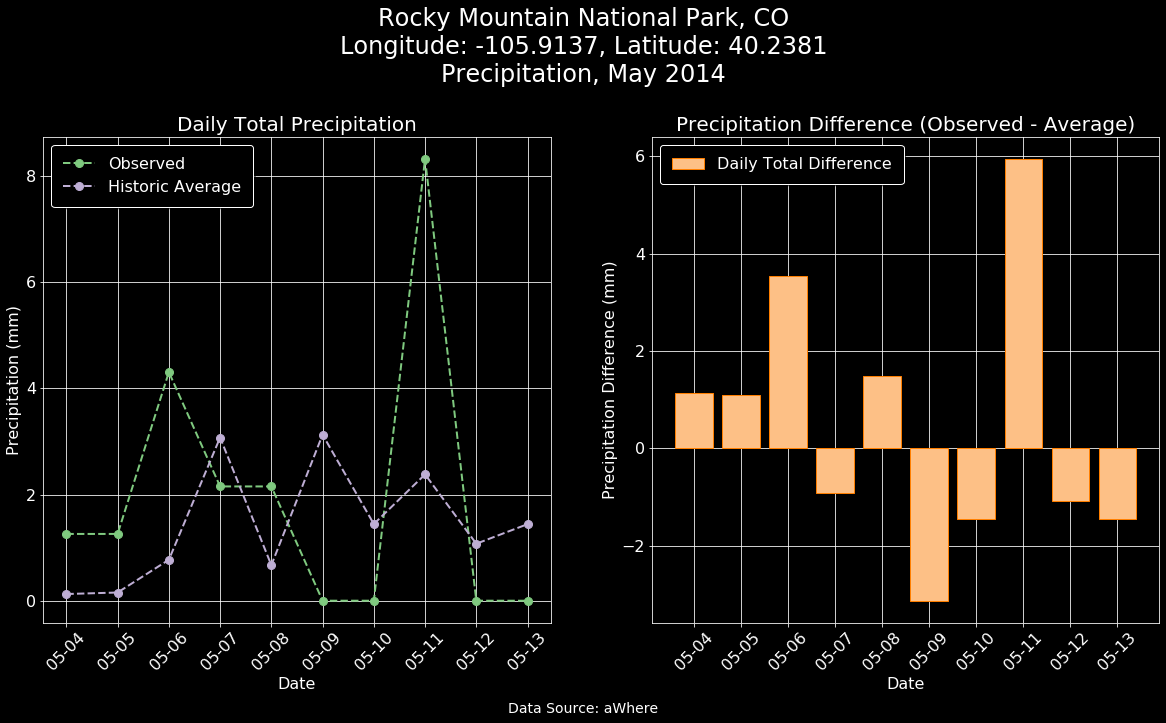

In [34]:
# Plot daily total comparison
with plt.style.context('dark_background'):

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Set overall title
    plt.suptitle(
        f'Rocky Mountain National Park, CO\nLongitude: {round(rmnp_grid_centroids[0][0], 4)}, Latitude: {round(rmnp_grid_centroids[0][1], 4)}\nPrecipitation, May 2014',
        fontsize=24)

    plt.subplots_adjust(top=0.8)

    # Subplot 1 - Observed Precipitation
    # Creat grid
    ax[0].grid(zorder=1)

    # Add daily observed total (line)
    ax[0].plot(
        rmnp_may_2014.precip_amount_mm, label='Observed',
        marker='o', color='#7fc97f', markersize=8,
        linewidth=2, linestyle='--', zorder=2)

    # Add daily average total (line)
    ax[0].plot(
        rmnp_may_2014.precip_avg_mm, label='Historic Average',
        marker='o', color='#beaed4', markersize=8,
        linewidth=2, linestyle='--', zorder=3)

    # Configure axes
    ax[0].set_xlabel("Date", fontsize=16)
    ax[0].set_ylabel("Precipitation (mm)", fontsize=16)
    ax[0].set_title("Daily Total Precipitation", fontsize=20)
    ax[0].tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)

    # Add legend
    ax[0].legend(borderpad=0.75, edgecolor='w', fontsize=16, shadow=True)

    # Subplot 2 - Precipitation Difference
    # Creat grid
    ax[1].grid(zorder=1)

    # Add difference (observed - norms)
    ax[1].bar(
        rmnp_may_2014.index.values, rmnp_may_2014.precip_daily_total_diff_mm,
        label='Daily Total Difference', zorder=2, edgecolor='#ff7f00',
        color='#fdc086', linewidth=1)

    # Configure axes
    ax[1].set_xlabel("Date", fontsize=16)
    ax[1].set_ylabel("Precipitation Difference (mm)", fontsize=16)
    ax[1].set_title(
        "Precipitation Difference (Observed - Average)", fontsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45) 

    # Add legend
    ax[1].legend(borderpad=0.75, edgecolor='w', fontsize=16, shadow=True)

    fig.text(0.5, 0, "Data Source: aWhere",
             ha='center', fontsize=14)
    
    plt.show()

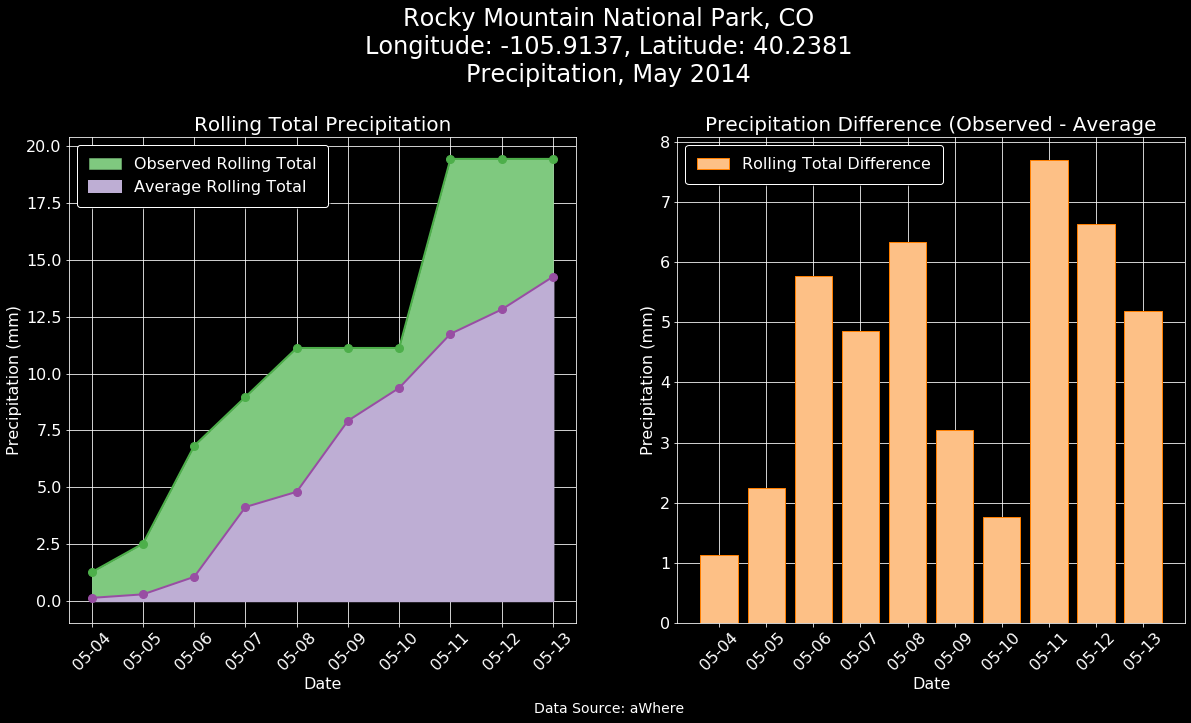

In [35]:
# Plot rolling total comparison
with plt.style.context('dark_background'):

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Set overall title
    plt.suptitle(
        f'Rocky Mountain National Park, CO\nLongitude: {round(rmnp_grid_centroids[0][0], 4)}, Latitude: {round(rmnp_grid_centroids[0][1], 4)}\nPrecipitation, May 2014',
        fontsize=24)

    plt.subplots_adjust(top=0.8)

    # Subplot 1 - Observed Precipitation
    # Creat grid
    ax[0].grid(zorder=1)

    # Add observed rolling total (line)
    ax[0].plot(
        rmnp_may_2014.precip_rolling_total_mm,
        marker='o', color='#4daf4a', markersize=8,
        linewidth=2, linestyle='-', zorder=2)

    # Add observed rolling total (fill)
    ax[0].fill_between(
        rmnp_may_2014.index.values, rmnp_may_2014.precip_rolling_total_mm,
        label='Observed Rolling Total', color='#7fc97f',
        linewidth=0.5, linestyle='-', zorder=2, alpha=1)

    # Add average rolling total (line)
    ax[0].plot(
        rmnp_may_2014.precip_rolling_total_average_mm,
        marker='o', color='#984ea3', markersize=8,
        linewidth=2, linestyle='-', zorder=3)

    # Add average rolling total (fill)
    ax[0].fill_between(
        rmnp_may_2014.index.values, rmnp_may_2014.precip_rolling_total_average_mm,
        label='Average Rolling Total', color='#beaed4',
        linewidth=2, linestyle='-', zorder=2, alpha=1)

    # Configure axes
    ax[0].set_xlabel("Date", fontsize=16)
    ax[0].set_ylabel("Precipitation (mm)", fontsize=16)
    ax[0].set_title("Rolling Total Precipitation", fontsize=20)
    ax[0].tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)

    # Add legend
    ax[0].legend(borderpad=0.75, edgecolor='w', fontsize=16, shadow=True)

    # Subplot 2 - Precipitation Difference
    # Creat grid
    ax[1].grid(zorder=1)

    # Add difference (observed - norms)
    ax[1].bar(
        rmnp_may_2014.index.values, rmnp_may_2014.precip_rolling_total_diff_mm,
        label='Rolling Total Difference', zorder=2,
        color='#fdc086', linewidth=1, edgecolor='#ff7f00')

    # Configure axes
    ax[1].set_xlabel("Date", fontsize=16)
    ax[1].set_ylabel("Precipitation (mm)", fontsize=16)
    ax[1].set_title(
        "Precipitation Difference (Observed - Average", fontsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)

    # Add legend
    ax[1].legend(borderpad=0.75, edgecolor='w', fontsize=16, shadow=True)
    
    fig.text(0.5, 0, "Data Source: aWhere",
             ha='center', fontsize=14)
    
    plt.show()

## Conclusion

While there are many items to improve upon from the Alpha (0.1) version of the Python solution to the aWhere API, the code created provides functionality to **get**, **extract**, and **clean** aWhere data. The Rocky Mountain National Park case study provides an example of how a workflow can use the Python solution to retrieve and visualize precipitation data. Next steps, in addition to improving the functionality of the Python solution, include integrating the returned data (for different study areas) with other GIS and remote sensing data, in support of fire risk and drought monitoring analyses.